# How much predictiveness does gene expression add over covariates for multiple mutations (using pca)? 

Some notes on the results displayed here:
1) Uses multiple genes
2) Analyzes training/testing auroc for 3 data sets
    -covariates only
    -expression only
    -covariates+expression
3) Pca performed instead of feature selection.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression

from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad

from IPython.core.debugger import Tracer
from IPython.display import display
import warnings
warnings.filterwarnings("ignore") # ignore deprecation warning for grid_scores_

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [3]:
path = os.path.join('..', '..', 'download', 'covariates.tsv')
covariates = pd.read_table(path, index_col=0)

CPU times: user 83.1 ms, sys: 15.8 ms, total: 98.9 ms
Wall time: 270 ms


In [15]:
# Select acronym_x and n_mutations_log1p covariates only
selected_cols = [col for col in covariates.columns if 'acronym_' in col]
selected_cols.append('n_mutations_log1p')
covariates = covariates[selected_cols]

In [44]:
path = os.path.join('..', '..', 'download', 'expression-matrix.tsv.bz2')
expression = pd.read_table(path, index_col=0)

CPU times: user 3min 4s, sys: 10.2 s, total: 3min 14s
Wall time: 3min 19s


In [45]:
path = os.path.join('..','..','download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 1min 46s, sys: 5.77 s, total: 1min 52s
Wall time: 1min 54s


In [67]:
# Pre-process expression data for use later
n_components = 65
scaled_expression = StandardScaler().fit_transform(expression)
pca = PCA(n_components).fit(scaled_expression)
explained_variance = pca.explained_variance_
expression_pca = pca.transform(scaled_expression)
expression_pca = pd.DataFrame(expression_pca)
expression_pca = expression_pca.set_index(expression.index.values)

CPU times: user 48.8 s, sys: 26.7 s, total: 1min 15s
Wall time: 1min 40s


In [75]:
print('fraction of variance explained: ' + str(pca.explained_variance_ratio_.sum()))

fraction of variance explained: 0.664258104557


In [47]:
# Create combo data set (processed expression + covariates)
combined = pd.concat([covariates,expression_pca],axis=1)
combined.shape

(7306, 135)

In [48]:
genes_LungCancer = {
    '207': 'AKT1', 
    '238': 'ALK',  
    '673': 'BRAF', 
    '4921':'DDR2',
    '1956':'EGFR',
    '2064':'ERBB2',
    '3845':'KRAS',
    '5604':'MAP2K1',
    '4893':'NRAS',
    '5290':'PIK3CA',
    '5728':'PTEN',
    '5979':'RET',
    '6016':'RIT1',
    '6098':'ROS1',
}

genes_TumorSuppressors = {
    '324': 'APC',  
    '672': 'BRCA1',  
    '675': 'BRCA2',
    '1029':'CDKN2A',
    '1630':'DCC',
    '4089':'SMAD4',
    '4087':'SMAD2',
    '4221':'MEN1',
    '4763':'NF1',
    '4771':'NF2',
    '7157':'TP53', 
    '5728':'PTEN', 
    '5925':'RB1',
    '7428':'VHL',
    '7486':'WRN',
    '7490':'WT1',
}

genes_Oncogenes = {
    '5155':'PDGFB', #growth factor
    '5159':'PDGFRB', #growth factor 
    '3791':'KDR', #receptor tyrosine kinases
    '25':'ABL1', #Cytoplasmic tyrosine kinases
    '6714':'SRC', #Cytoplasmic tyrosine kinases
    '5894':'RAF1',#cytoplasmic serine kinases
    '3265':'HRAS',#regulatory GTPases
    '4609':'MYC',#Transcription factors
    '2353':'FOS',#Transcription factors
}

mutations = {**genes_LungCancer, **genes_TumorSuppressors, **genes_Oncogenes}

In [49]:
# Define model
param_fixed = {
    'loss': 'log',
    'penalty': 'elasticnet',
}
param_grid = {
    'classify__alpha': [10 ** x for x in range(-6, 1)],
    'classify__l1_ratio': [0],
}

pipeline = Pipeline(steps=[
    ('standardize', StandardScaler()),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced', loss=param_fixed['loss'], 
                               penalty=param_fixed['penalty']))
])

pipeline = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc')

In [50]:
# Helper training/evaluation functions.
def train_and_evaluate(data, pipeline):
    """
    Train each model using grid search, and ouput:
    1) all_best_estimator_aurocs: contains aurocs for mean_cv, train, and test for chosen grid parameters
    2) all_grid_aurocs: contains aurocs for each hyperparameter-fold combo in grid search
    """
    all_best_estimator_aurocs = list()
    all_grid_aurocs = pd.DataFrame()
    for m in list(mutations):
        best_estimator_aurocs, grid_aurocs = get_aurocs(data, Y[m], pipeline)
        best_estimator_aurocs['symbol'] = mutations[m]
        grid_aurocs['symbol'] = mutations[m]
        all_grid_aurocs = all_grid_aurocs.append(grid_aurocs, ignore_index = True)
        all_best_estimator_aurocs.append(best_estimator_aurocs) 
    all_best_estimator_aurocs = pd.DataFrame(all_best_estimator_aurocs)
    return all_best_estimator_aurocs, all_grid_aurocs

def get_aurocs(X, y, pipeline):
    """
    Fit the classifier for the given mutation (y) and output predictions for it
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
    pipeline.fit(X=X_train, y=y_train)
    y_pred_train = pipeline.decision_function(X_train)
    y_pred_test = pipeline.decision_function(X_test)
    grid_aurocs = grid_scores_to_df(pipeline.grid_scores_) 
    best_estimator_aurocs = pd.Series()
    best_estimator_aurocs['mean_cv_auroc'] = grid_aurocs['fold_mean'].max()
    best_estimator_aurocs['training_auroc'] = roc_auc_score(y_train, y_pred_train)
    best_estimator_aurocs['testing_auroc'] = roc_auc_score(y_test, y_pred_test)
    best_estimator_aurocs['best_alpha'] = pipeline.best_params_['classify__alpha']
    best_estimator_aurocs['best_11_ratio'] = pipeline.best_params_['classify__l1_ratio']
    best_estimator_aurocs['n_positive_mutation'] = sum(y==1)
    best_estimator_aurocs['n_negative_mutation'] = sum(y==0)
    return best_estimator_aurocs, grid_aurocs

def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to 
    a tidy pandas DataFrame where each row is a hyperparameter and each column a fold.
    """
    rows = []
    for grid_score in grid_scores:
        row = np.concatenate(([grid_score.parameters['classify__alpha']],
                              [grid_score.parameters['classify__l1_ratio']],
                            grid_score.cv_validation_scores))
        rows.append(row)
    grid_aurocs = pd.DataFrame(rows,columns=['alpha', 'l1_ratio','fold_1','fold_2','fold_3'])
    grid_aurocs['fold_mean'] = grid_aurocs.iloc[:,2:4].mean(axis=1)
    grid_aurocs['fold_std'] = grid_aurocs.iloc[:,2:4].std(axis=1)
    return grid_aurocs

In [77]:
# Helper visualization functions.
def visualize_grid_aurocs(grid_aurocs, gene_type=None, ax=None):
    """
    Visualize grid search results for each mutation-alpha parameter combo.
    """
    if ax==None: f, ax = plt.subplots()
    grid_aurocs_mat = pd.pivot_table(grid_aurocs, values='fold_mean', index='symbol', columns='alpha')
    order = grid_aurocs['symbol'].unique()
    grid_aurocs_mat = grid_aurocs_mat.reindex(grid_aurocs['symbol'].unique()) # sort so labels in original order
    sns.heatmap(grid_aurocs_mat, annot=True, fmt='.2', ax=ax)
    ax.set_ylabel('Symbol')
    ax.set_xlabel('Regularization strength multiplier (alpha)')
    plt.setp(ax.get_yticklabels(), rotation=0)
    if gene_type != None: ax.set_title(gene_type, fontsize=15)

def visualize_best_estimator_aurocs(estimator_aurocs, gene_type=None, ax=None, training_data_type=None):
    """
    Creates a bar plot of mean_cv_auroc, training_auroc, and testing_auroc for each gene in df
    """
    plot_df = pd.melt(estimator_aurocs, id_vars='symbol', value_vars=['mean_cv_auroc', 'training_auroc', 
                                                'testing_auroc'], var_name='kind', value_name='aurocs')
    ax = sns.barplot(y='symbol', x='aurocs', hue='kind', data=plot_df,ax=ax)
    if training_data_type == 'marginal_gain': ax.set(xlabel='delta aurocs')
    else: ax.set(xlabel='aurocs')
    ax.legend(bbox_to_anchor=(.65, 1.1), loc=2, borderaxespad=0.)
    plt.setp(ax.get_yticklabels(), rotation=0)
    if gene_type != None: ax.set_title(gene_type, fontsize=15)
            
def visualize_categories(data, plot_type, training_data_type):
    """
    Wrapper that separates genes into categories and calls visualization subroutines.  
    """
    f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20,10))
    for gene_type in ['lung', 'suppressor', 'onco']:
        if gene_type == 'lung': 
            gene_list = genes_LungCancer.values()
            ax = ax1
        elif gene_type == 'suppressor': 
            gene_list = genes_TumorSuppressors.values()
            ax = ax2
        elif gene_type == 'onco': 
            gene_list = genes_Oncogenes.values()
            ax = ax3    
        plot_df = data[data['symbol'].isin(gene_list)]
        plt.yticks(rotation=90)
        if plot_type == 'best_estimator': visualize_best_estimator_aurocs(plot_df, gene_type, ax, training_data_type)
        elif plot_type == 'grid': visualize_grid_aurocs(plot_df, gene_type, ax)
        f.suptitle(training_data_type, fontsize=20)

In [52]:
%%time
# Train with covariates data
all_best_estimator_aurocs_covariates, all_grid_aurocs_covariates = train_and_evaluate(covariates, pipeline)

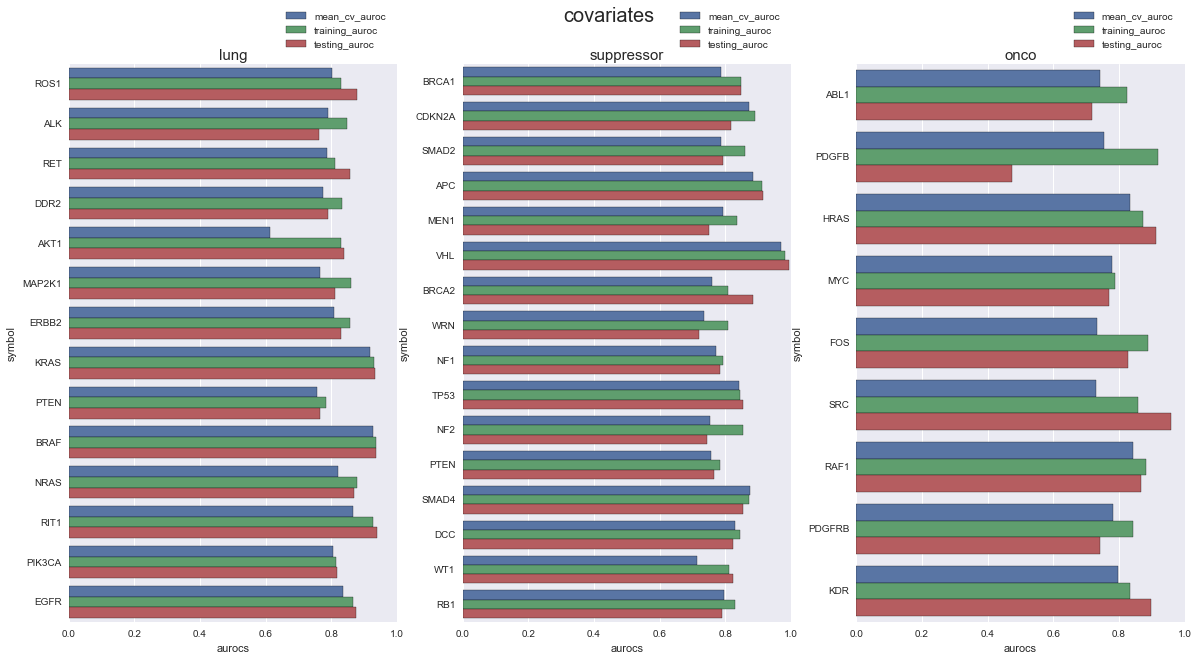

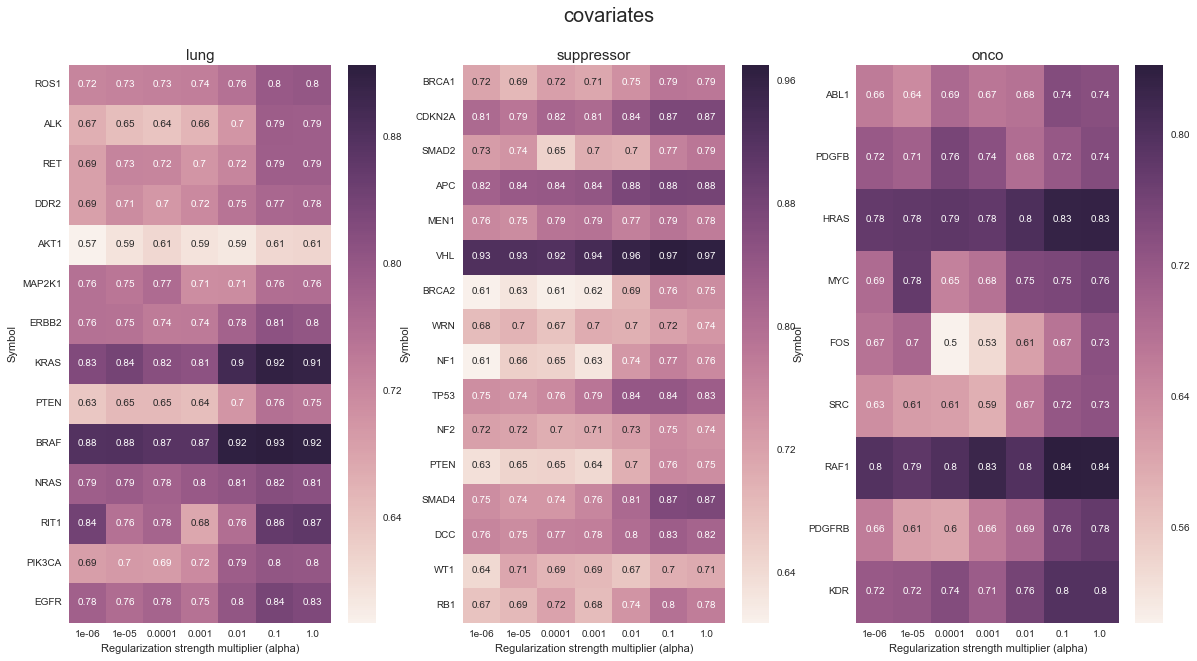

In [78]:
# Visualize covariates data
visualize_categories(all_best_estimator_aurocs_covariates, 'best_estimator', 'covariates')
visualize_categories(all_grid_aurocs_covariates, 'grid', 'covariates')

In [54]:
%%time
# Train expression data
all_best_estimator_aurocs_expression, all_grid_aurocs_expression = train_and_evaluate(expression_pca, pipeline)

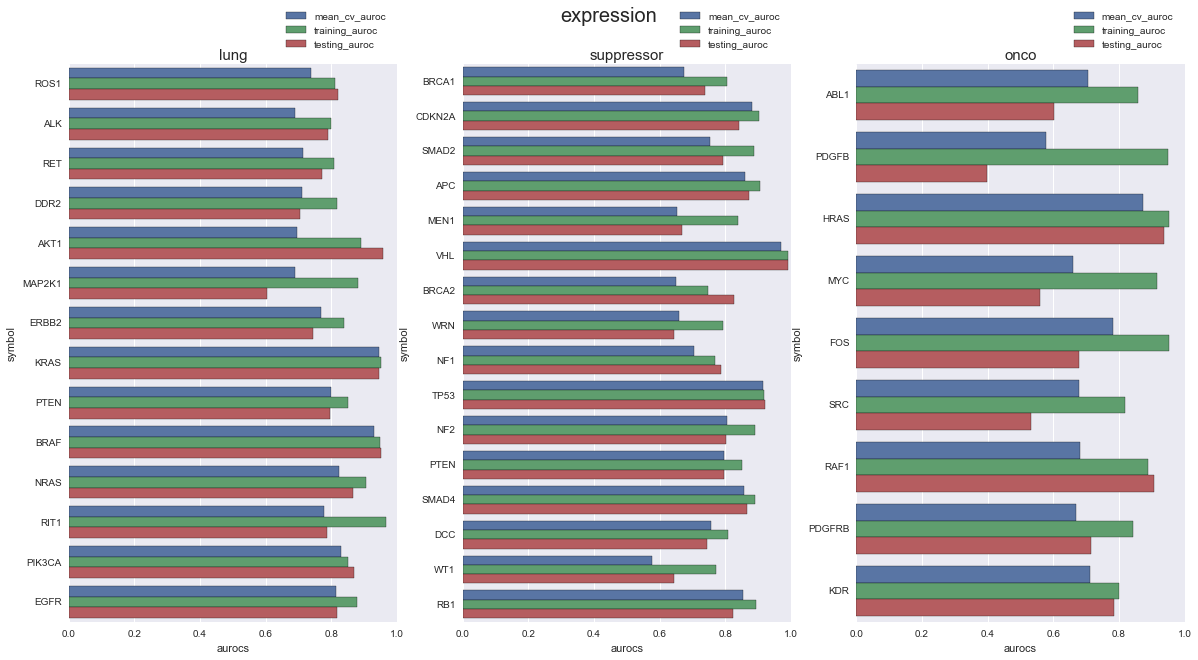

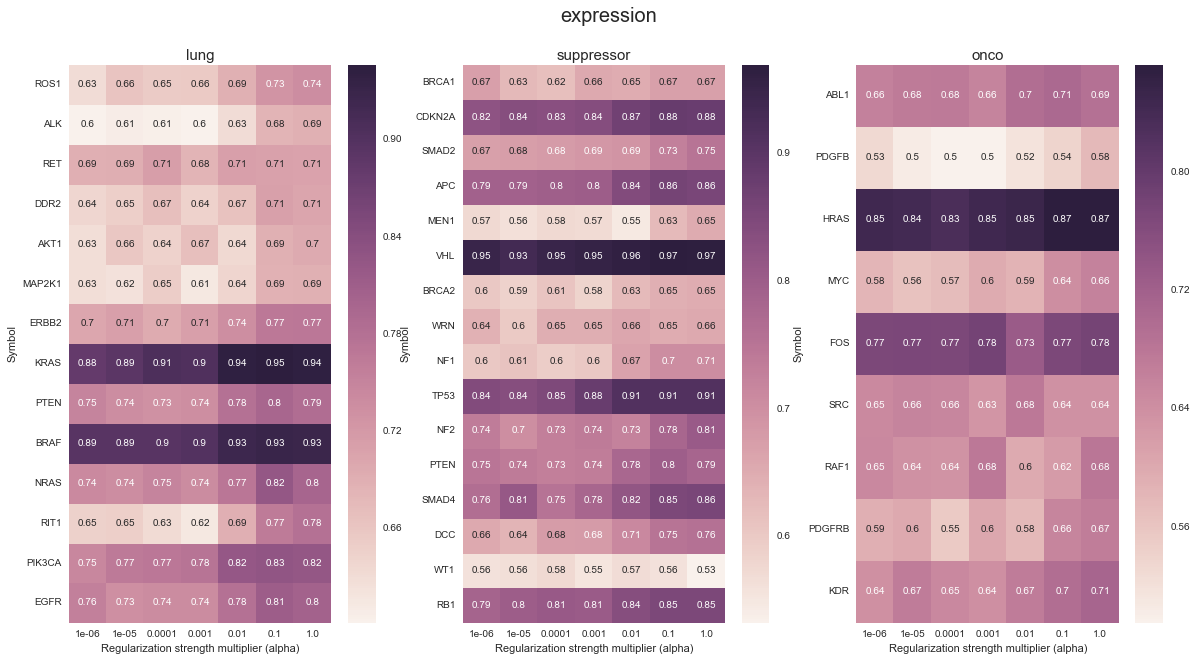

In [79]:
# Visualize expression data
visualize_categories(all_best_estimator_aurocs_expression, 'best_estimator', 'expression')
visualize_categories(all_grid_aurocs_expression, 'grid', 'expression')

In [56]:
%%time
# Train with combined data
all_best_estimator_aurocs_combined, all_grid_aurocs_combined = train_and_evaluate(combined, pipeline)

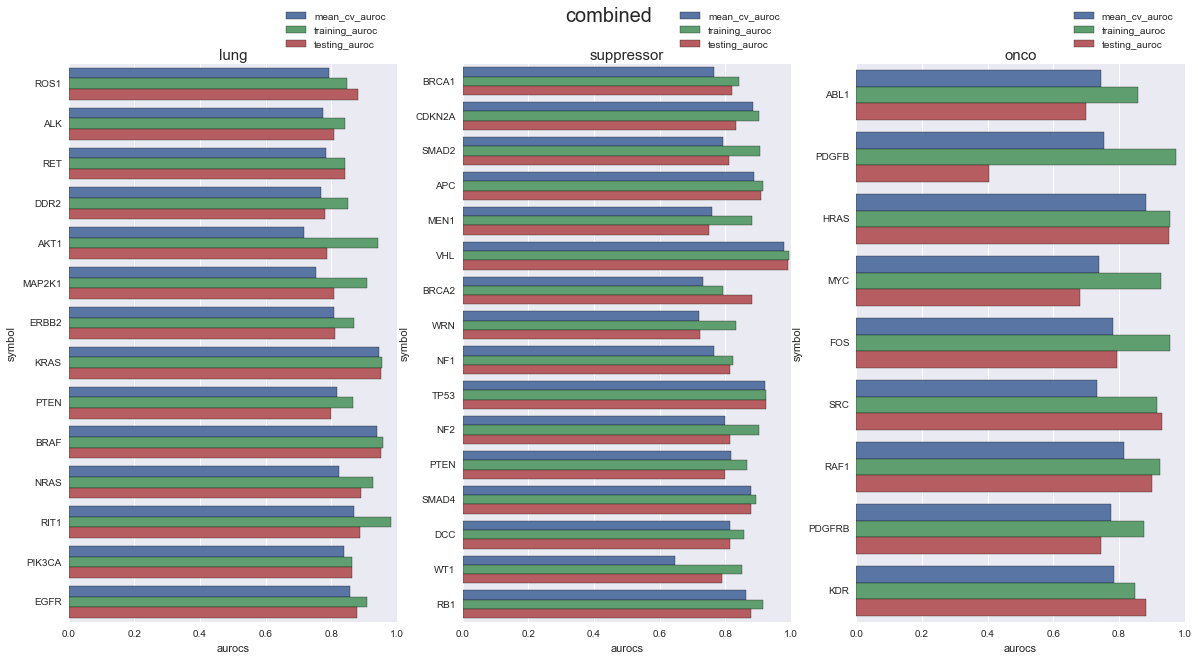

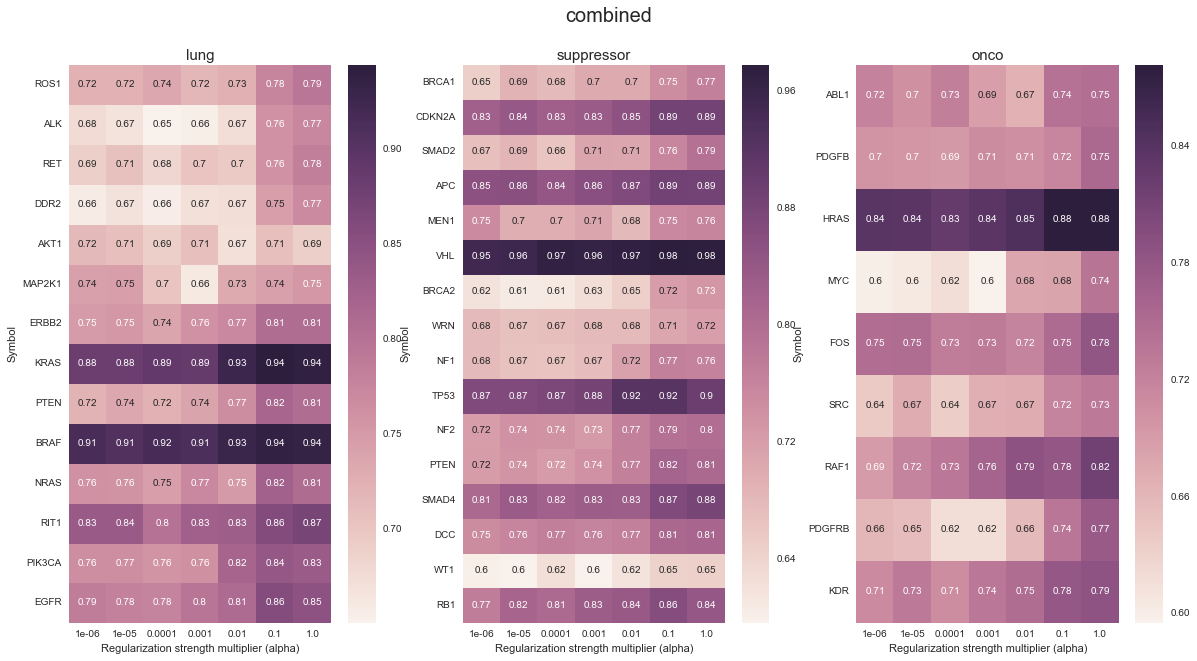

In [80]:
# Visualize combined data
visualize_categories(all_best_estimator_aurocs_combined, 'best_estimator', 'combined')
visualize_categories(all_grid_aurocs_combined, 'grid', 'combined')

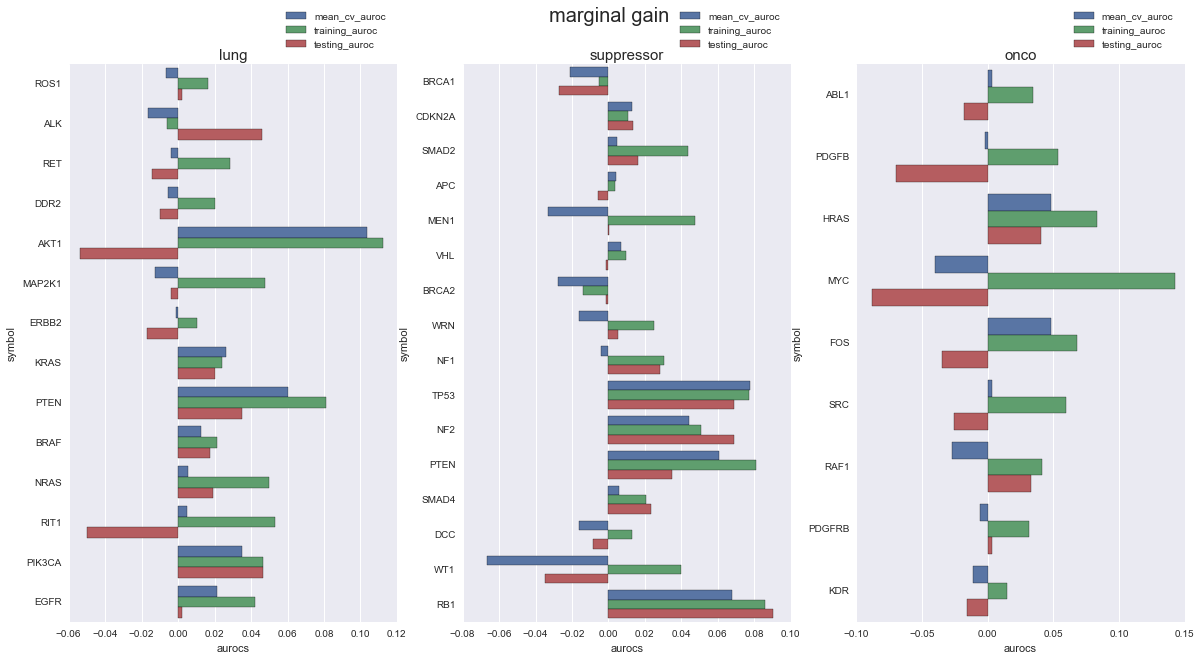

In [81]:
# Display difference in auroc between combined and covariates only 
diff_aurocs = all_best_estimator_aurocs_combined.iloc[:,0:3] - all_best_estimator_aurocs_covariates.iloc[:,0:3]
diff_aurocs['symbol'] = all_best_estimator_aurocs_combined.iloc[:,-1]
visualize_categories(diff_aurocs, 'best_estimator', 'marginal gain')

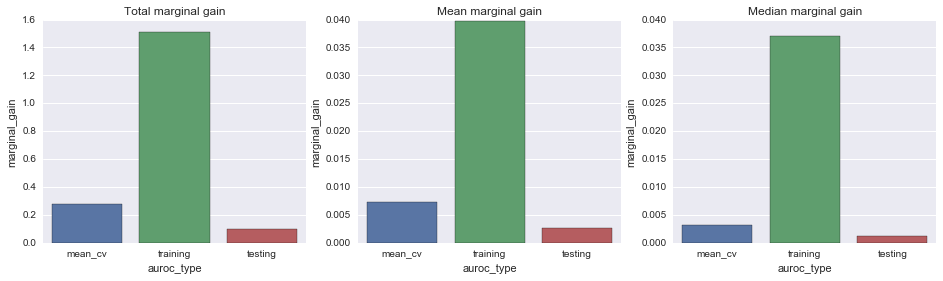

In [59]:
# Summary stats on marginal gain.
def visualize_marginal_gain(data, title, ax):
    marginal_gain_df = pd.DataFrame({'auroc_type': ['mean_cv', 'training', 'testing'], 'marginal_gain': data})
    sns.barplot(x='auroc_type',y='marginal_gain',data=marginal_gain_df,ax=ax)
    ax.set(ylabel='marginal_gain')
    ax.set_title(title)

f, (ax1, ax2,ax3) = plt.subplots(ncols=3, figsize=(16,4))
t1, t2, t3 = diff_aurocs['mean_cv_auroc'].sum(), diff_aurocs['training_auroc'].sum(),diff_aurocs['testing_auroc'].sum()
a1,a2,a3 = diff_aurocs['mean_cv_auroc'].mean(), diff_aurocs['training_auroc'].mean(),diff_aurocs['testing_auroc'].mean()
m1,m2,m3 = diff_aurocs['mean_cv_auroc'].median(), diff_aurocs['training_auroc'].median(),diff_aurocs['testing_auroc'].median()
visualize_marginal_gain([t1,t2,t3], 'Total marginal gain', ax1)
visualize_marginal_gain([a1,a2,a3], 'Mean marginal gain',ax2)
visualize_marginal_gain([m1,m2,m3], 'Median marginal gain',ax3)

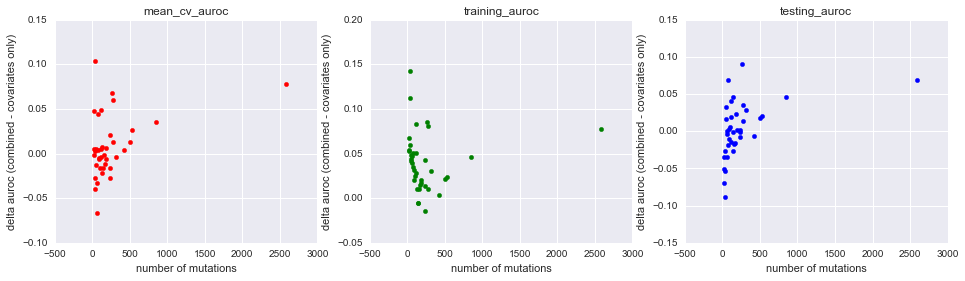

In [76]:
# Is there a relationship between marginal gain and number of mutations?
def visualize_marginal_vs_n_mutations(auroc_type,color,ax):
    x = np.array(all_best_estimator_aurocs_combined['n_positive_mutation']); x = x.reshape(len(x),1)
    y = np.array(diff_aurocs[auroc_type]); y = y.reshape(len(y),1)
    ax.scatter(x=x, y=y,color=color)
    ax.set(xlabel="number of mutations")
    ax.set(ylabel="delta auroc (combined - covariates only)")
    ax.set_title(auroc_type)
    
f, (ax1, ax2,ax3) = plt.subplots(ncols=3, figsize=(16,4))
visualize_marginal_vs_n_mutations('mean_cv_auroc','red',ax=ax1)
visualize_marginal_vs_n_mutations('training_auroc','green',ax=ax2)
visualize_marginal_vs_n_mutations('testing_auroc','blue',ax=ax3)